<a href="https://colab.research.google.com/github/anasraza1234/agentic-ai-chatbot-prototype-1/blob/main/Agentic_AI_Chatbot_Prototype_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective:

Create a chatbot prototype that talks to users, remembers what they say during conversation, and helps them solve problems.

## Project Requirements:

- ***Choose Your Niche:*** Pick a specific group of people or industry to help with your chatbot (e.g., students, healthcare, customer service).

- ***Make Smart Conversations:*** Make sure the chatbot answers correctly and understands what users want. Use Prompt Engineering.

- ***Add Useful Tools:*** Give the chatbot features like helping users submit complaints, giving outfit ideas, or making study plans.

- ***Short-Term Memory:*** Make the chatbot remember the current conversation to give better answers.

- ***Use Google Colab:*** Build and test your chatbot using this platform.

## Deliverables:

- A working chatbot prototype - Google Collab Link.

- A list of tools and examples of how the chatbot can help people.

# Setup

- First, install the required packages:

In [1]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_google_genai

- Next, set your API keys:

In [2]:
import os
from google.colab import userdata

GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

- Setting up LLM model

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    api_key=GOOGLE_API_KEY
)

llm.invoke("hi")

AIMessage(content='Hi there! How can I help you today?\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-d6270eb7-0104-4909-be8e-1e6a659bd112-0', usage_metadata={'input_tokens': 2, 'output_tokens': 11, 'total_tokens': 13, 'input_token_details': {'cache_read': 0}})

- Now, creating a chatbot for the students of computer science, which have useful tools and shot-term memory.

In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage


# Memory for short-term conversation
conversation_memory = {}

def remember_user_input(key, value):
    """Stores user input in conversation memory."""
    conversation_memory[key] = value


# State definition
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Initialize StateGraph
graph_builder = StateGraph(State)


# Tools

def healthcare_code_explainer(code_snippet: str) -> str:
    """Explains the given healthcare-related code snippet in simple terms."""
    prompt = f"Explain the following healthcare-related code in simple terms:\n\n{code_snippet}"
    return llm.invoke(prompt)

def generate_healthcare_cheat_sheet(topic: str) -> str:
    """Generates a cheat sheet for a given healthcare topic."""
    prompt = f"Create a detailed cheat sheet for the healthcare topic: {topic}. Include key points and examples."
    return llm.invoke(prompt)

def healthcare_todo_list(tasks: str) -> str:
    """Organizes healthcare tasks into a smart to-do list."""
    prompt = f"Organize the following healthcare tasks into a prioritized to-do list with deadlines:\n{tasks}"
    return llm.invoke(prompt)

def healthcare_interview_preparation(question: str) -> str:
    """Provides detailed interview preparation for healthcare roles."""
    prompt = f"Provide a list of common healthcare interview questions and some tips for preparing for an interview:\n{question}"
    return llm.invoke(prompt)




# Combine all tools
tools = [healthcare_code_explainer,  generate_healthcare_cheat_sheet, healthcare_todo_list, healthcare_interview_preparation]

# Initialize LLM
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    api_key=GOOGLE_API_KEY
)
llm_with_tools = llm.bind_tools(tools)


# System message
sys_msg = SystemMessage(content="You are a helpful assistant for healthcare issues.")


# Node
def assistant(state: MessagesState) -> MessagesState:
    # Extract the last user message
    last_message = state["messages"][-1] if state["messages"] else None

    # Check if the last message is a HumanMessage
    if isinstance(last_message, HumanMessage):
        # Remember the user input
        remember_user_input("last_user_input", last_message.content)

    # Prepare the response with memory context
    memory_context = ""
    if "last_user_input" in conversation_memory:
        memory_context = f"Previously, you mentioned: {conversation_memory['last_user_input']}\n"

    # Invoke the LLM with the system message, memory context, and current messages
    response = llm_with_tools.invoke([sys_msg, memory_context] + state["messages"])

    return {"messages": [response]}


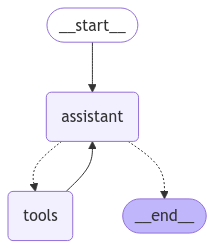

In [5]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph

# Graph
builder: StateGraph = StateGraph(MessagesState)

# Define nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph: CompiledStateGraph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

- **Explains code snippets in simple terms, making it easier for people to understand their health issues.**

In [6]:
messages = [HumanMessage(content="Can you suggest about my health issues")]
messages = react_graph.invoke({"messages": messages})

In [7]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Can you suggest about my health issues
================================== Ai Message ==================================

I cannot provide specific medical advice or diagnoses.  To get help with your health issues, please consult a doctor or other qualified healthcare professional.  They can properly assess your situation and provide appropriate recommendations.


In [8]:
print(conversation_memory)

{'last_user_input': 'Can you suggest about my health issues'}


- **Creates concise cheat sheets for various topics in healthcare, summarizing key concepts and examples.**

In [9]:
messages = [HumanMessage(content="can you make me healthcare suggestion")]
messages = react_graph.invoke({"messages": messages})

In [10]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

can you make me health care suggestion
================================== Ai Message ==================================

To provide you with relevant healthcare suggestions, I need more information about your health and goals.  What specific areas are you interested in? For example, are you looking for:

* **Suggestions for improving your diet and nutrition?**  (e.g.,  losing weight, increasing energy levels, managing a specific condition)
* **Advice on increasing physical activity and exercise?** (e.g., starting a new workout routine, finding activities you enjoy)
* **Information on managing a specific health condition?** (e.g., diabetes, heart disease, high blood pressure)
* **Tips for stress management and mental well-being?** (e.g., relaxation techniques, mindfulness exercises)
* **Guidance on preventative care?** (e.g., vaccinations, screenings)

Please tell me more about what you'd like help with so

In [11]:
print(conversation_memory)

{'last_user_input': 'can you make me health care suggestion'}


- **Organizes tasks into a prioritized to-do list, helping students manage their assignments and projects effectively.**

In [12]:
messages = [HumanMessage(content="I need to finish my health care issues")]
messages = react_graph.invoke({"messages": messages})

In [13]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

I need to finish my health care issues
================================== Ai Message ==================================

Please provide me with more details about your healthcare issues so I can assist you.  For example, are you trying to:

* **Schedule appointments?**  Tell me what kind of appointment you need and when you're available.
* **Understand a diagnosis?**  Tell me the diagnosis and what you'd like to know.
* **Manage a chronic condition?** Tell me the condition and what support you need.
* **Find resources?** Tell me what kind of resources you're looking for (e.g., support groups, financial assistance).
* **Organize your healthcare tasks?**  List the tasks you need to complete.

The more information you give me, the better I can help.


In [14]:
print(conversation_memory)

{'last_user_input': 'I need to finish my health care issues'}


In [ ]:
def stream_graph_updates(user_input: str):
    for event in react_graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: when else we can use panadol tablet
Assistant: I cannot provide medical advice.  Panadol (paracetamol) is used to relieve pain and fever.  However,  **always consult a doctor or pharmacist** before using Panadol or any medication, especially if you have pre-existing health conditions or are taking other medications. They can advise you on the appropriate dosage and whether it's suitable for your specific needs.  Improper use can be harmful.

User: 
Assistant: I need more context to understand what you're referring to.  Please provide the previous conversation or information you'd like me to consider.

User: i am feeling pain in my hand 
Assistant: I am a large language model.  While I can process information and respond to your statement about hand pain, I cannot provide medical advice.  To determine the cause of your hand pain and receive appropriate treatment, you should consult a doctor or other qualified healthcare professional.  They can properly diagnose the issue and recom